# The Great LIGO Detection Algorithm

Winn Koster  |  wkoster@haverford.edu  |  Originally written as part of a problem set for Astro 344: Gravitational Waves

NOTE THAT THIS NOTEBOOK IS A MODIFICATION OF A NOTEBOOK PROVIDED BY THE LIGO CONSORTIUM. ALL MARKDOWN TEXT IS MY OWN, and it should be clear from the markdown where the LIGO code ends and my own code begins. I have added inline comments where I think they are necessary (flagging as "WK") for the LIGO portion, then continued with my own detection algorithm, which uses long and short time moving averages to flag a detection. By playing around you can see that in order to detect all four events, several false detections must be tolerated. Future programs would benefit from either a functional fit of a "chirp" in Fourier space, or a neural network to eventually train the algorithm. With just a handful of detections, however, the neural network solution is still a long way off for me, LIGO, or anyone else.

THIS NOTEBOOK WILL NOT RUN WITHOUT THE SUPPORTING FILES, which can be found [here](https://losc.ligo.org/tutorials/). I feel a little weird about just uploading the LIGO data to GitHub, even if they do supply it on that page. Downloading it from the consortium website should be trivial.

In this notebook we'll be exploring the LIGO data and writing an algorithm to flag possible detections. After starting this in the LIGO template notebook, I decided that I'd rather just write my own notebook from scratch (and steal a bunch of the code from the LIGO original). This is mostly because we've already spent some time getting to know the notebook, and it was getting annoying remembering which cells had already been run and needed to be rerun every time I changed between GW events.

Finally, I've included all comments from the original code, and added my own where I think they are needed to clarify things. My comments will be denoted with the prefix "WK".

## Setting up Python Packages

We start by importing our favorite packages to run Python. This cell is a combination of the LIGO notebook cells 1 and 2.

In [144]:
#WK: This is all pretty basic stuff.
# I've made it its own cell becuase the imports take a little while and only need to be run once.
# We're importing the basic modules for math and FFTs. There's also a module to parse the dataset, which is in json format.

# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt                       #WK: When you import packages you can refer to them as anything. It is standard practive to refer to matplotlib's plotting package as "plt".
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

# want plots?
#WK: Set to 0 if you don't want plots.
make_plots = 1
plottype = "png"
#plottype = "pdf"

## Importing Data and the LIGO Data Reduction Pipeline 

Now that we have Python set up and ready to recieve data, plot, and do anything else we need, it's time to add the data play around with it. There are two cells in this section: The first one you get to play around with and the second one you definitely should not. I usually don't use Jupyter, but when I do I like to divide things into "the things you can play with and specify" and "the code that does things with what you specify -- don't change this part unless you're changing the functionality".

**How does it work under the hood?** (Skip to the next section if you just want to run it)

The first cell allows us to specify our event. There are a handful of detection events included, and we need to let Python know which one to load. The options are all included below, and all but one should be commented out. Note that if you leave multiple definitions uncommented it won't throw an error, but will instead simply take the last one you specify. Computers are dumb and do dumb things if you don't specify exactly what you want.

The second cell is the functional portion of the code; it takes the inputs from the first cell and perfoms operations. This is part of the data reduction pipeline, which I've cobbled together from about a dozen cells in the LIGO notebook. The notebook includes a lot of intermediate plots and steps, which now that we've seen what the code can do, no longer need. For this cell, I've taken everything that the program needs to run, and nothing it doesn't.

**How do I make it run?** Specify which GW event you want by selecting it in the first cell and runnning it. Then run the second cell without touching any of the code inside. This will spit out the power spectrum and spectrograph plots, which will allow us to search by eye for the GW events.

**What do I find when I run the code?** Some of the events are visible by eye, while others are not. I've got some notes on this below.

**GW150914** This is definitely the strongest of the signals (but still looks a little pathetic on the huge plot to be honest). It can be easily seen by eye if you know what to look for. 

**GW151226** This can be seen faintly on the Hanford spectrum only. And even then, only because I knew to look for it at around 250 Hz and 0 seconds.

**LVT151012** I can see a faint spike on the Hanford spectrum (which seems to be the less noisy of the two instruments, in general), but absolutely nothing on Livingston, which appears to have aliasing of some kind on the low (>200 Hz) frequencies. I'm suprised this wasn't statistically significant, as it appears, at least visually, to be stronger than GW151226.

**GW170104** There's a strong, clean signal on both detectors. This time, Livingston clearly has a stronger detection.


In [145]:
#WK: Pick a card, any card... Pro tip: the first one on the list is the strongest, so I'd stick with that one as a proof of concept.

eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'


Reading in parameters for event GW150914
{'fn_L1': 'L-L1_LOSC_4_V1-1126259446-32.hdf5', 'fn_H1': 'H-H1_LOSC_4_V1-1126259446-32.hdf5', 'f_min': 10.0, 'name': 'GW150914', 'utcevent': '2015-09-14T09:50:45.44', 'a2': -0.769, 'fs': 4096, 'fn_template': 'GW150914_4_template.hdf5', 'm1': 41.743, 'approx': 'lalsim.SEOBNRv2', 'm2': 29.237, 'a1': 0.355, 'tevent': 1126259462.44, 'fband': [43.0, 300.0]}
time_H1: len, min, mean, max =  131072 1126259446.0 1126259462.0 1126259478.0
strain_H1: len, min, mean, max =  131072 -7.11996338709e-19 8.73279794057e-23 7.71483633765e-19
strain_L1: len, min, mean, max =  131072 -2.6788089173e-18 -1.82870749189e-18 -7.69266177024e-19
1126259462.44
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


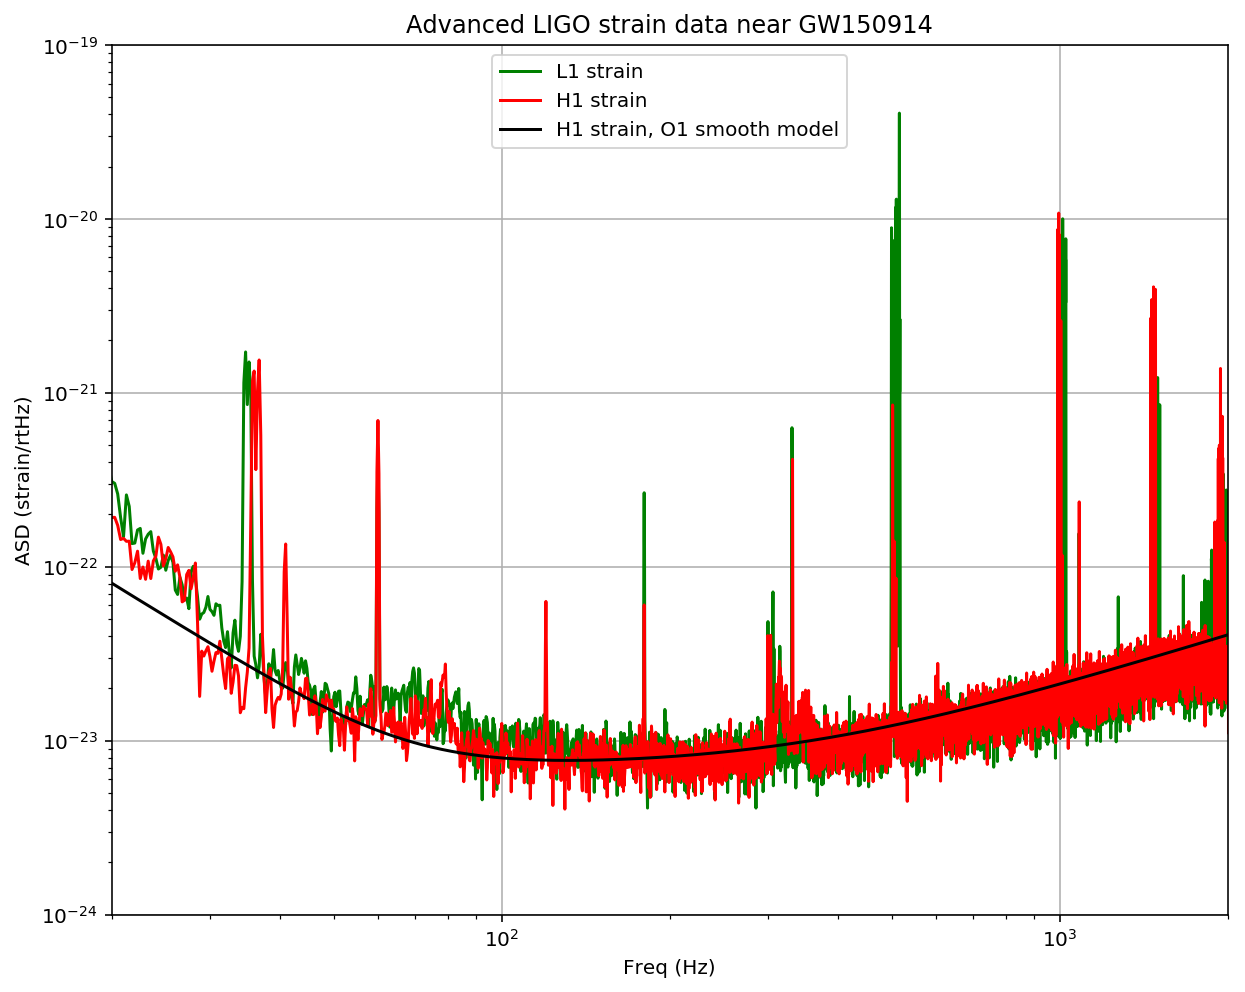

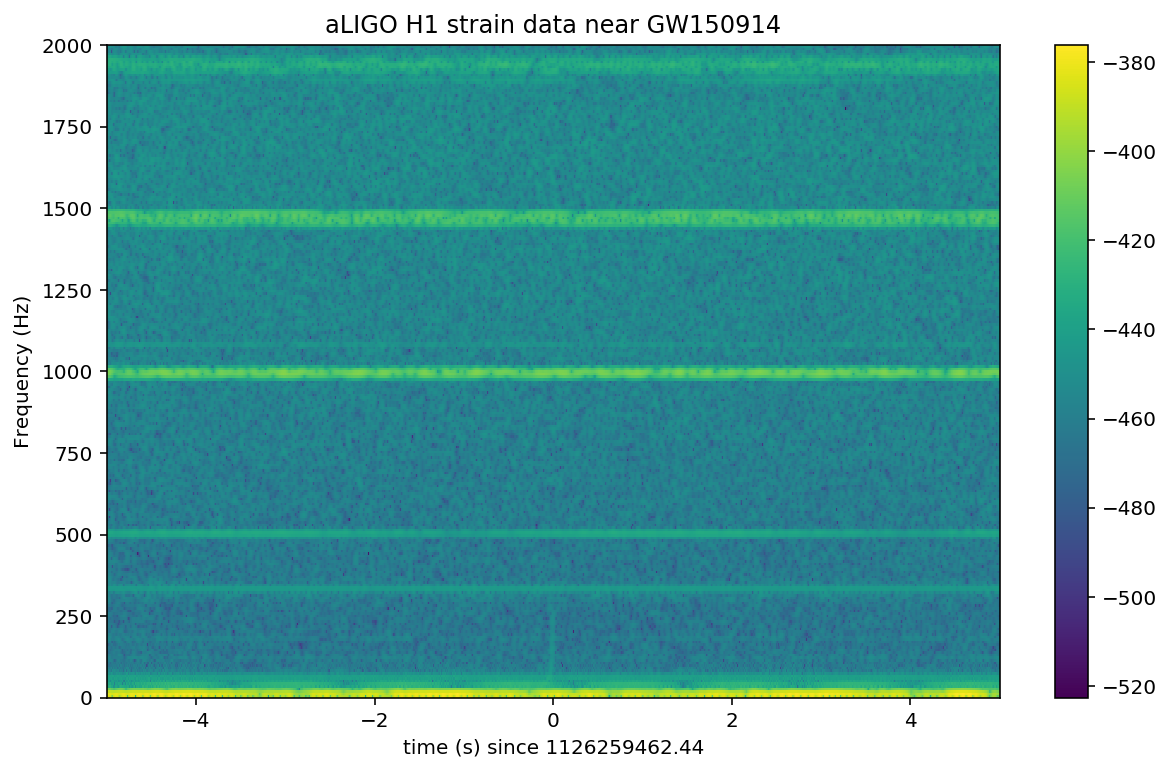

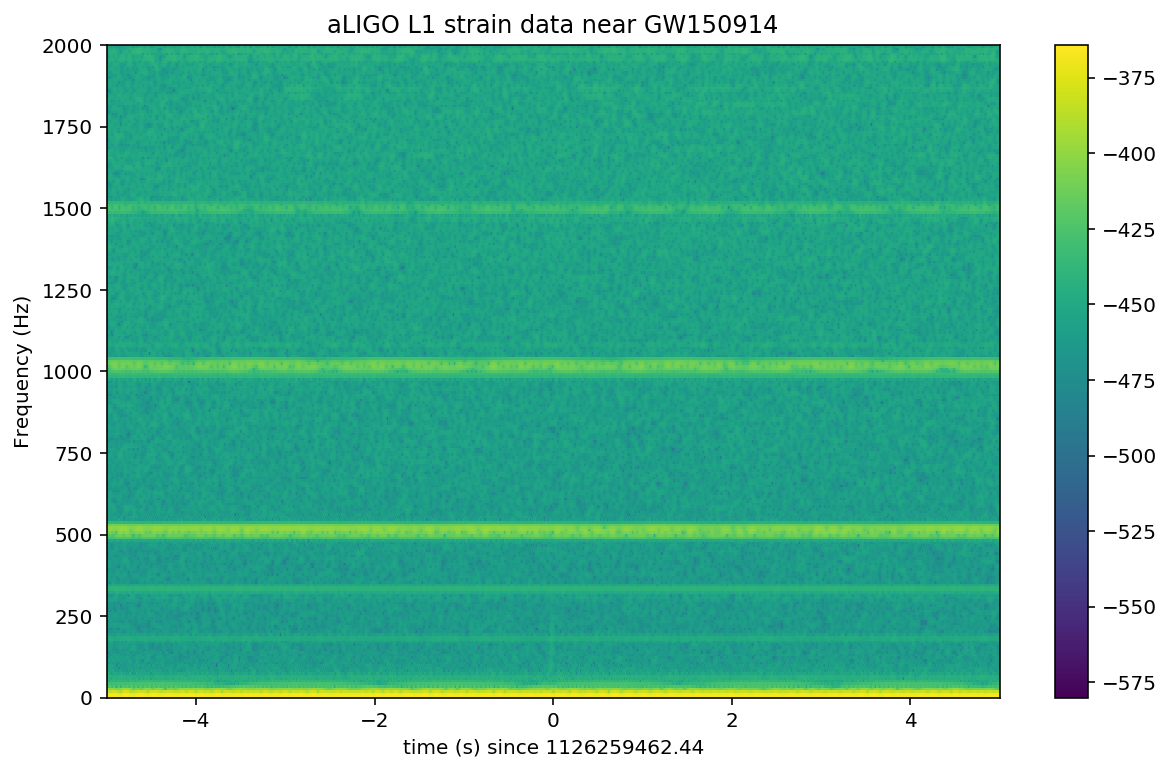

In [146]:
#WK: This is cobbled together from the other LIGO cells.
# The gist is that it loads the data from a json file, with the name specified by "eventname" above.
# It takes the data from the file and converts everything into arrays, which Python can do math on.
# The arrays are the raw data, and we perform math to whiten the data and otherwise reduce it to usable format.
# The arrays are FFT'ed at some point as well.
# Finally, we can plot the data using a few different visualization methods, all provided via matplotlib.


# Read the event properties from a local json file
#fnjson = "BBH_events_v3.json"
fnjson = "BBH_events_v2.json"   #Added this because this is the filename I found in the directory
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])    # WK: leaving some verbose feedback here deliberately
print(event)

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
    
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
    
#FFT stuffs read in from previous cells    
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)
    
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization
    
#Start by stealing the plotting code from the cells below.
#Next we need to define the event for each cell to plot them all.

if make_plots:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    #WK: Windowing is super important to get a good roll-off for your spectrum. Otherwise, the hard boundary imposes a weird square wave which will appear as a ~1/f series of peaks in your FFT that ruin everything
    #WK: https://en.wikipedia.org/wiki/Window_function
    
    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    spec_cmap='viridis'   #WK: If this doesn't work, switch the color map back to ocean (see commented line below)
    #spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)

    # Plot the L1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram.'+plottype)



#WK: You may get a deprecation warning. This is fine. Python is smart enough to turn a float (eg: 3.00) into an integer (eg: 3). Not all languages (looking at you, Fortran) can do this, especially the high performance ones. Cost of doing business.
# Below we should get a nice FFT of the signal or "strain" coming in from the ligo data. Some frequencies can be attributed to noise (eg: 60 Hz noise, 500 Hz mirror vibrational modes, higher order mirror modes, etc.)
# The O1 smooth model is something the folks at LIGO dreamed up to "whiten" or flatten the fourier spectrum

## Plotting the data with filters

Everything we've just done upstairs is all good and well, but we didn't actually *use* the whitening routine. Note that the plot simply plots "Strain_H1", while we have a whitening algorithm that takes this data and spits out "Srain_H1_whitenbp". Let's explore the different options.

The cell below makes three plots, all for the Hanford detector (same logic applies for Livingston, but I figured it would just be comfusing to make six plots). The plots are as follows:

1. Raw spectrogram for Hanford. This is the same as the Hanford plot above.
2. Whitened spectrogram. Note that the background appears, visually, to be flat. The signal is easy to spot.
3. Whitened spectrogram with a bandpass filter to cut out the high frequency white noise that we don't care about. A cleaned high frequency spectrum means the signal is even easier to spot.

**Note** that if you'd like to change events, you need to go back to the previous two cells and run them again. This cell exists primarily so that you can see the difference between the filters.


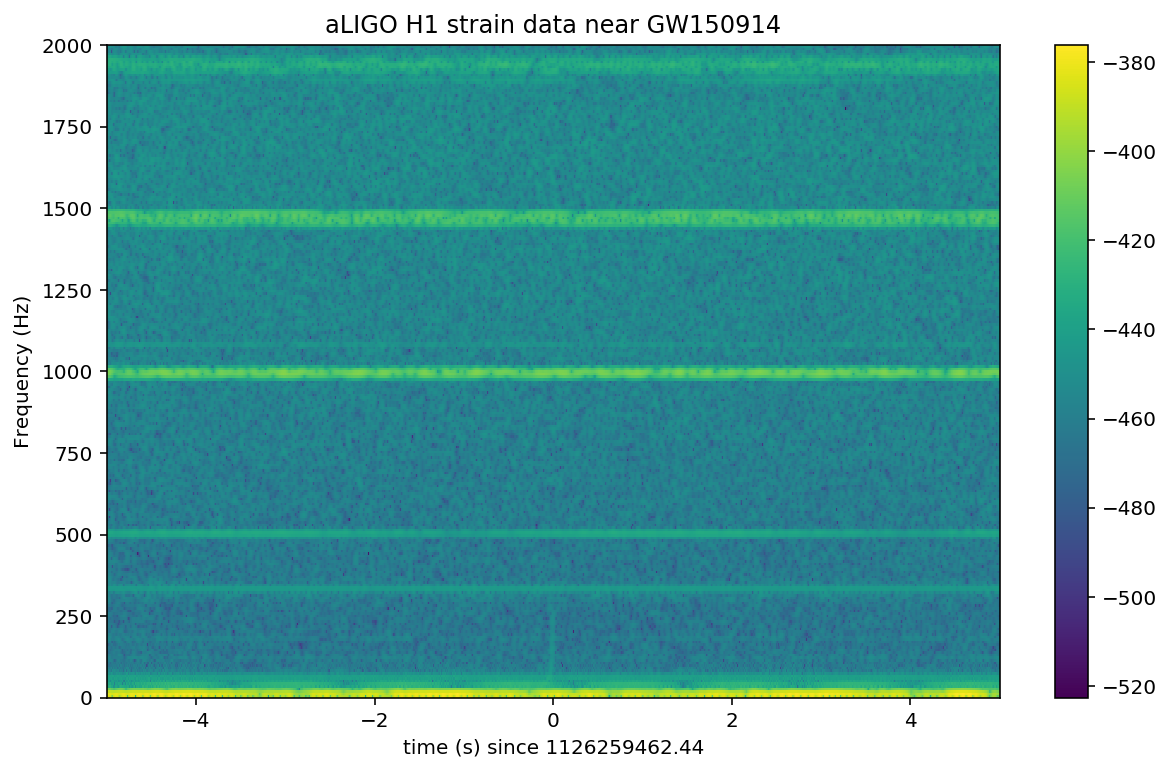

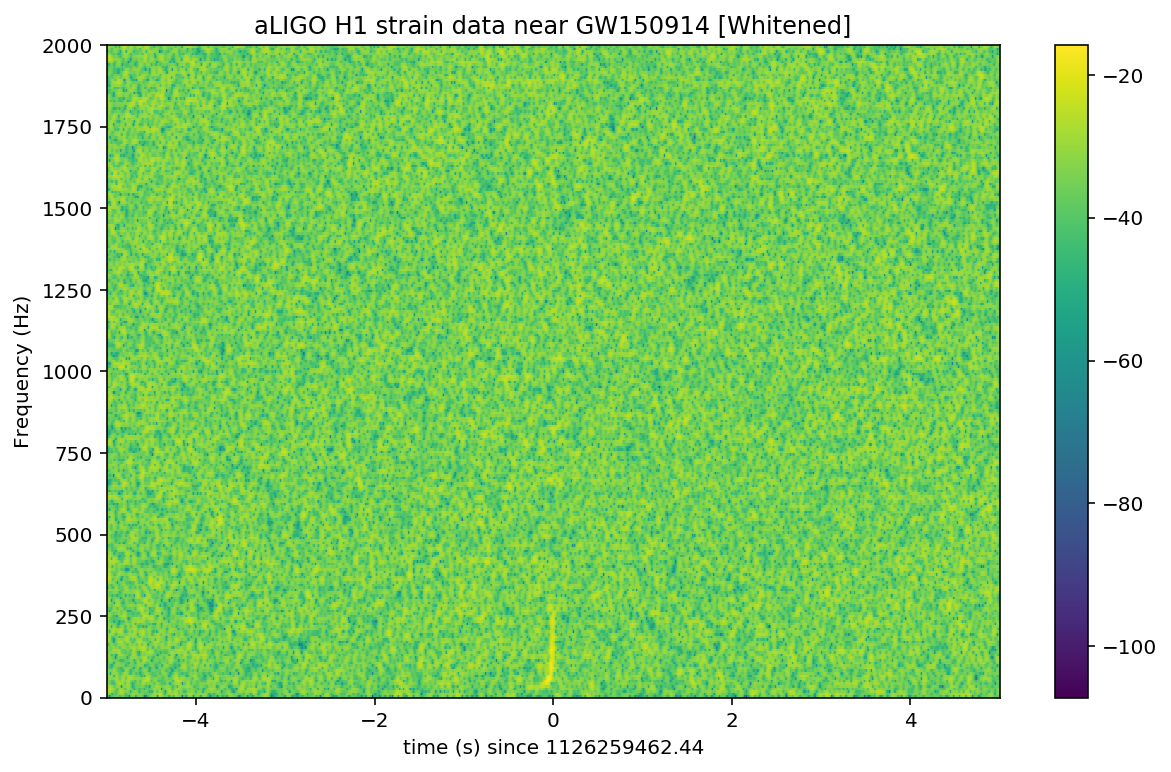

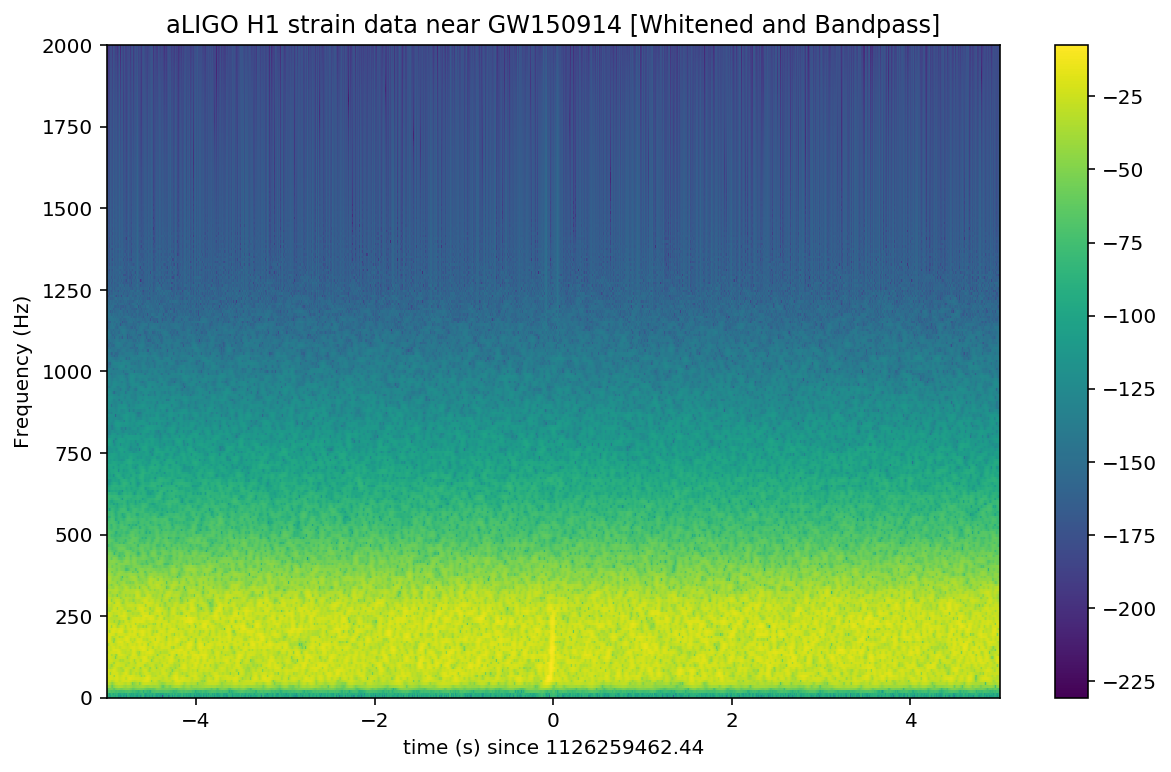

In [147]:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    #WK: Windowing is super important to get a good roll-off for your spectrum. Otherwise, the hard boundary imposes a weird square wave which will appear as a ~1/f series of peaks in your FFT that ruin everything
    #WK: https://en.wikipedia.org/wiki/Window_function
    
    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    spec_cmap='viridis'   #WK: If this doesn't work, switch the color map back to ocean (see commented line below)
    #spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)
    
    # Plot the H1 spectrogram with WHITENING:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname+' [Whitened]')
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)
    
    # Plot the H1 spectrogram with WHITENING AND BANDPASS:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1_whitenbp[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname+' [Whitened and Bandpass]')
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)
    

## Building a Detection Algorithm

Suppose we're (quite reasonably) not in the mood to search for these events by eye. We need to write a detection algorithm that searches for them. Problem is, computers are pretty bad at guessing and seeing patterns, so we need to define some rules for the computer to follow.

To this end, we're using excess power to make our algorithm. The idea here is that a certain amount of power due to noise is coming through the detector at all times (eg: mirror resonance at 500Hz and higher modes), which forms a baseline power for the instrument. When a wave comes through, we expect a spike in that power. If we're feeling really cheeky, we can even search for an excess power only in a specified bandwidth (such as 60Hz to 250Hz), which might yeild an even stronger signal to noise ratio.

From here on out, all code is my own.

## What does it actually do?

Before I write a single line of code, I like to explain to myself in English what I want to accomplish. Not the overarching goal --- that part is easy --- but the gritty details of every step. That gives me a sense of what will be required, and I'm not as suprised. It also serves as a sanity check: If I can't explain it in words, I *definitely* won't be able to write it in code.

**So what do we actually want our code to do?**

1. Start by pulling all the data for one time interval (but all frequencies) and saving this to an array. We will use this later to compute power and average power.

1a. We could, if we wanted, do this only for a specific bandwidth. This is icing on the cake, and we'll revisit this once we have a working prototype.

1b. We could also subtract bandwidths known to be associated with experiment noise. I don't think it would be too hard to skip over 475-525 Hz and others. Or if that screws with the array shapes too much to make it possible to plot (it probably will), manually set them to zero. 

2. Come up with an RMS by squaring everything in the array. This step shouldn't be too difficult, especially if we're using numpy arrays, which allow you to do a lot more math.
3. Build a baseline power curve by taking the average over some amount of time. We need to do some tweaking here to figure out exactly how long that time should be. I can envision a 500ms moving average, in which for every time, t, we take the average power from t - 0.5 seconds through t.
4. Take the instantanous power (OR a much shorter moving average, eg: 25ms). This should be very easy after step 3, as we're basically just taking the last entry in the array for step 3.
5. Build a residual or "excess" power curve by subtracting the baseline value from the instantaneous value.
6. Specify the some value at which the computer should say "Hey, I found something!"
7. Have the computer print these values.

7a. Find some way to throw out values if they're back to back. Say the computer takes 35 samples through the gravitational wave event, it will flag this as 35 detections. Obviously, that's not ideal. Once again, this is icing on the cake.

And that's about it. You may noticed that I've completely skipped over discussion of the two different detectors. This is because I'm not really sure what I should do. I *think* the code should run seperately for each detector since the waves can be separated by some amount of time, but it might also make more sense to combine the two signals for extra SNR. For now, my plan is to get the code working on one detector, and then revisit this issue once I know more about the details of this.

## Step 1: What does the data even look like?

The first thing I'm doing is just playing around with the shapes of the data. From the cells below, I see how the indxt works, and I may try to copy that for a moving average that only takes data from inside that range. Anyway, I can see that every timestamp has a single value. So I'm not 100% sure how the FFT works quite yet. I suppose I could just plot the total power across all frequencies, but I don't know if that makes sense.

I can also see that we're taking +/- 5 seconds (out of a total 32 seconds) for the indxt call, by looking at the lengths of the three arrays.

In [51]:

#WK: Let's just see what this looks like.
print('H1 Strain, whitened, bandpass:')
print(strain_H1_whitenbp)
print(np.shape(strain_H1_whitenbp))
print(' ')

#WK: Comparing the raw data to the whitened and bandpass:
print('H1 Strain, raw data:')
print(strain_H1)
print(np.shape(strain_H1))
print(' ')

#WK: So now let's add the indxt and see if it changes.
print('H1 Strain, whitened, bandpass, shorter time:')
print(strain_H1_whitenbp[indxt])
print(np.shape(strain_H1_whitenbp[indxt]))

H1 Strain, whitened, bandpass:
[  -3.89988444   76.79174083  149.26962661 ..., -185.13795357 -112.8390111
  -32.41733761]
(131072,)
 
H1 Strain, raw data:
[  2.26386630e-19   2.45062539e-19   2.60734924e-19 ...,   4.42571750e-20
   7.28690972e-20   7.00518869e-20]
(131072,)
 
H1 Strain, whitened, bandpass, shorter time:
[-0.71895504 -0.90145611 -0.98168469 ...,  2.10217689  2.19163287
  2.19449716]
(40960,)


In [52]:
meanvalue = np.mean(strain_H1_whitenbp[indxt])

fractional_signal = np.zeros(len(strain_H1_whitenbp[indxt]))
dank_array = strain_H1_whitenbp[indxt]


i=0
while i < len(fractional_signal):
    fractional_signal[i] = ( dank_array[i] - meanvalue ) / meanvalue
    #print(str(i)+'out of '+str(len(fractional_signal)))     #troubleshooting
    i = i+1
    
    
print(fractional_signal)
print(np.shape(fractional_signal))
print(meanvalue)


[ -3562.32402545  -4466.33805287  -4863.74812625 ...,  10412.07540627
  10855.19313078  10869.38133456]
(40960,)
0.00020187858134


In [53]:
#WK: So how do the spectrograms above work? Because I like the data there. It's nice and visual...

print(np.shape(spec_H1))
print(np.shape(freqs))
print(np.shape(bins))

# So from this we can see that the frequency axis has 257 entries (256 from the FFT plus zero)
# The amplitude is defined by spec_H1, and the bins are related to time such as delta t = indxt / len(bins)

(257, 1265)
(257,)
(1265,)


I'm very quickly realizing that I prefer working with the nice Fourier Transformed data that's given on the spectrogram. So in the cell below, I've been playing around with the data structure to understand how to use it. Generally speaking, if you can print it, you can do math on it. In the following cells, I load data from the time and frequency components, and plot.

The first entry of spec_H1 is...
[  6.90149727e-10   3.37000698e-10   8.13441873e-10 ...,   6.19624920e-10
   2.18082362e-09   2.22885585e-09]
This sub-array has a length of 1265 and corresponds to the amplitude at 0.0 Hz across the time axis.
 
If we wanted, say, the third entry of this sub-array, we can grab it by asking nicely...
The third entry of this sub-array is 8.13441873163e-10
This is the amplitude for a frequency of 0.0Hz and a time bin of 0.078125
 


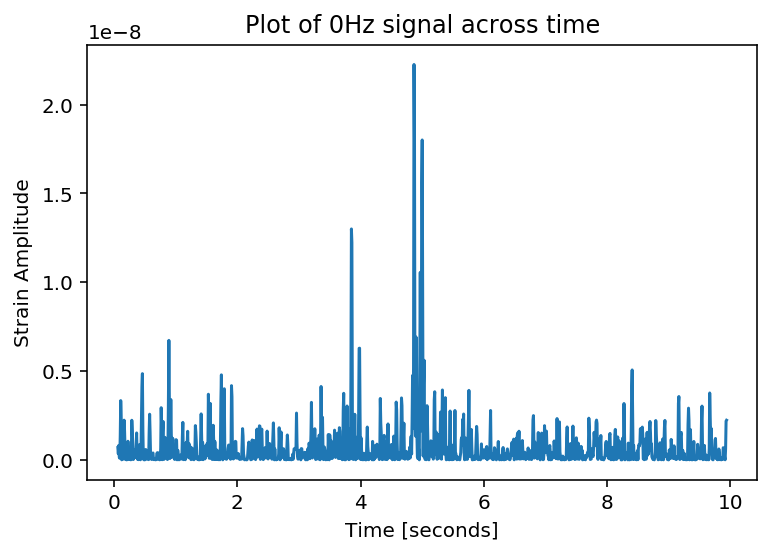

In [54]:
# How do I talk to the data in the freqs, which is a rectangle?

print('The first entry of spec_H1 is...')
print(spec_H1[0])
print('This sub-array has a length of '+str(len(spec_H1[0]))+' and corresponds to the amplitude at 0.0 Hz across the time axis.')
print(' ')

print('If we wanted, say, the third entry of this sub-array, we can grab it by asking nicely...')
print('The third entry of this sub-array is '+str(spec_H1[0][2])) #check with print above
print('This is the amplitude for a frequency of '+str(freqs[0])+'Hz and a time bin of '+str(bins[2]))

#WK: Note that python starts with the first entry as zero. so for array A, entry fourteen is called as A[13]
# In the same vein, the first entry is A[0] and the last entry can be called as A[-1] regardless of array length.
# This last bit is UNIQUE TO PYTHON, don't be trying this in your other codes.
print(' ')

#Make a basic plot of the 0Hz signal
plt.plot(bins,spec_H1[0][::])
plt.title('Plot of 0Hz signal across time')
plt.xlabel('Time [seconds]')
plt.ylabel('Strain Amplitude')



We can also ask for the combined values across a frequency this way...
For a frequency of 0.0Hz and a time bin of 0.0625, the amplitude is 6.90149727245e-10
For a frequency of 8.0Hz and a time bin of 0.0625, the amplitude is 2.73177768294e-09
For a frequency of 16.0Hz and a time bin of 0.0625, the amplitude is 1.43361084285e-07


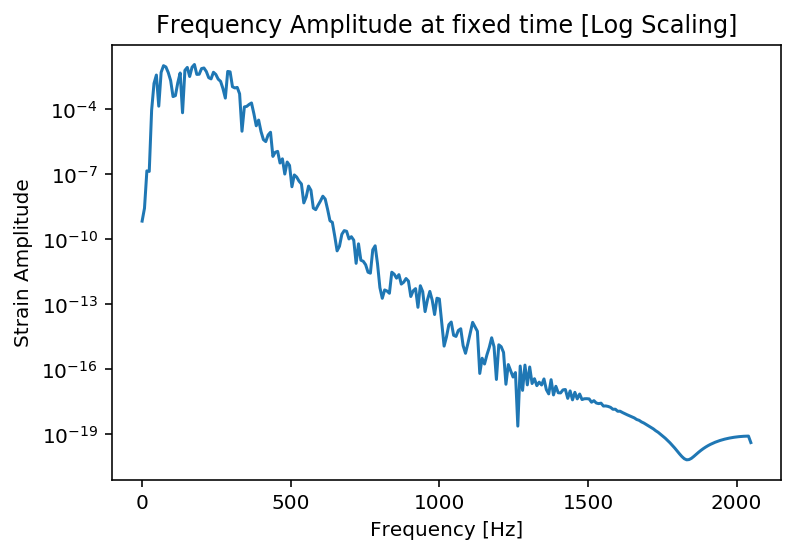

In [55]:
print('We can also ask for the combined values across a frequency this way...')
print('For a frequency of '+str(freqs[0])+'Hz and a time bin of '+str(bins[0])+', the amplitude is '+str(spec_H1[0][0]))
print('For a frequency of '+str(freqs[1])+'Hz and a time bin of '+str(bins[0])+', the amplitude is '+str(spec_H1[1][0]))
print('For a frequency of '+str(freqs[2])+'Hz and a time bin of '+str(bins[0])+', the amplitude is '+str(spec_H1[2][0]))


frequency_amplitudes = []     #defining an empty array for the freq amplitudes to be written to

#This is a loop that iterates across all frequencies for a fixed time, and writes them into the array we just defined
i=0
while i < 257:
    frequency_amplitudes.append(spec_H1[i][0])
    i = i+1
#print(np.shape(frequency_amplitudes))    #troubleshooting

#make a basic plot of the frequency amplitude (Fourier transform) for the first timestamp.
plt.semilogy(freqs,frequency_amplitudes)
plt.title('Frequency Amplitude at fixed time [Log Scaling]')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain Amplitude')

The next step here is to combine these two plots into one (I also think we have to square everything at some point too). Basically, we want the area under the curve for the second plot, but for every time. This will ultimately be plotted in a manner similar to that of the first plot.

I've been having some trouble with the 2d array notation, which is why the second plot was generated using a loop instead of just an index entry. Not sure how to fix this the *right* way, but I can add a second loop to accomplish this.

## Using the non-spectral data

After taking a break from this project, I came back asking why I was even bothering to use the spectral fourier decomposition if we already have a perfectly good bandpass filter. The FFT is great because it allows us to only look at a specific range (eg: 75Hz to 250Hz), but the bandpass already filters to this approxomate range.

Below I've plotted just the bandpass for H1, and the signal sticks out like a sore thumb.

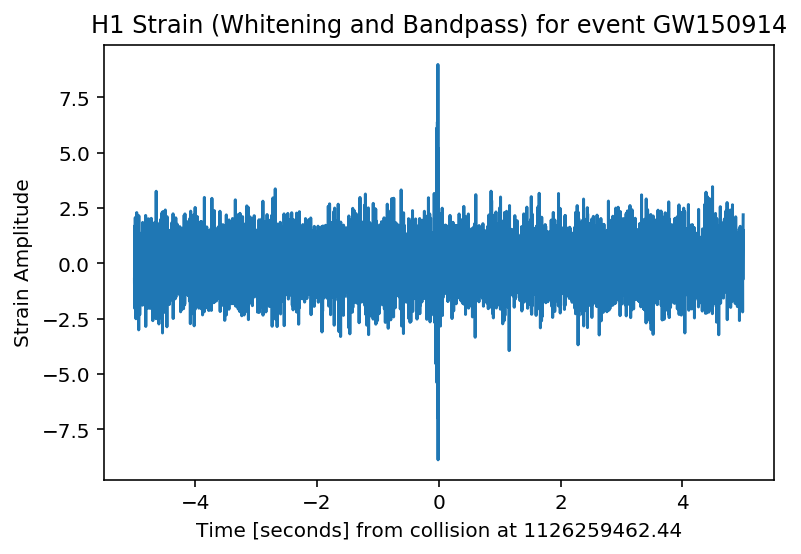

In [56]:
plt.plot(time[indxt]-tevent,strain_H1_whitenbp[indxt])
plt.title('H1 Strain (Whitening and Bandpass) for event '+str(eventname))
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('Strain Amplitude')

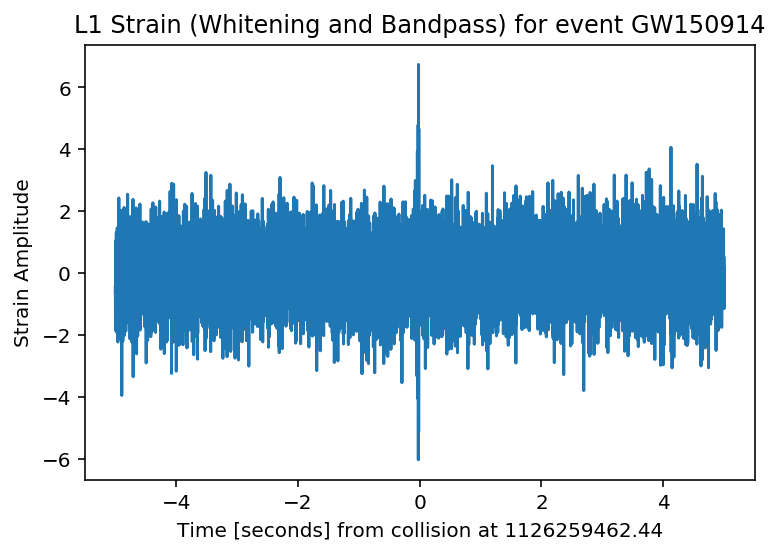

In [57]:
plt.plot(time[indxt]-tevent,strain_L1_whitenbp[indxt])
plt.title('L1 Strain (Whitening and Bandpass) for event '+str(eventname))
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('Strain Amplitude')

Yeah, now I'm realizing that everything I've already done on this is kind of a waste beause this is more or less exactly what I want.

## Generating a SNR plot

For this part, we convert the plot above into an SNR value by taking the RMS value of the entire thing vs the RMS at a specific point. Or make some moving averages. Or both!

In [148]:
# Take all the datapoints and square them. Use the np.array() because np is smarter than vanilla python?
H1_WBP_squared = np.array(strain_H1_whitenbp[indxt]**2)
L1_WBP_squared = np.array(strain_L1_whitenbp[indxt]**2)

# Now take an average for the 
H1_mean_power = np.mean(H1_WBP_squared)
L1_mean_power = np.mean(L1_WBP_squared)

print(H1_mean_power)
print(L1_mean_power)

# It would seem I'm wrong about using np.array(). The code below proves it's not actually required.
# Numpy arrays usually are smarter and/or intuitive, but I guess in this instance it doesn't matter
#a = strain_H1_whitenbp[indxt]**2
#print(np.shape(a))
#print(strain_H1_whitenbp[indxt][0]**2)
#print(a[0])

0.971770716482
0.951622458868


In the previous cell we just took the average of the squared strain values. The squared strain is related to the power, and so the average power represents our baseline noise value. So in the plots below, we plot the SNR (signal over noise) using the baseline noise value we just derived.

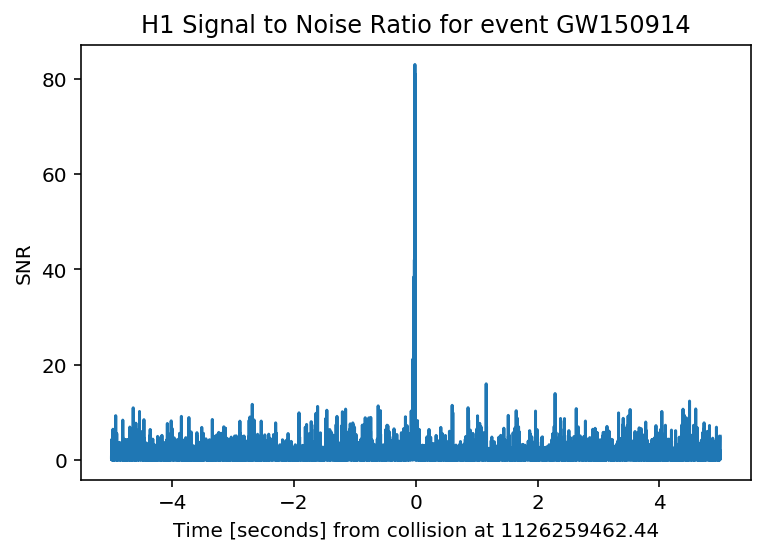

In [149]:
plt.plot(time[indxt]-tevent,H1_WBP_squared/H1_mean_power)
plt.title('H1 Signal to Noise Ratio for event '+str(eventname))
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('SNR')

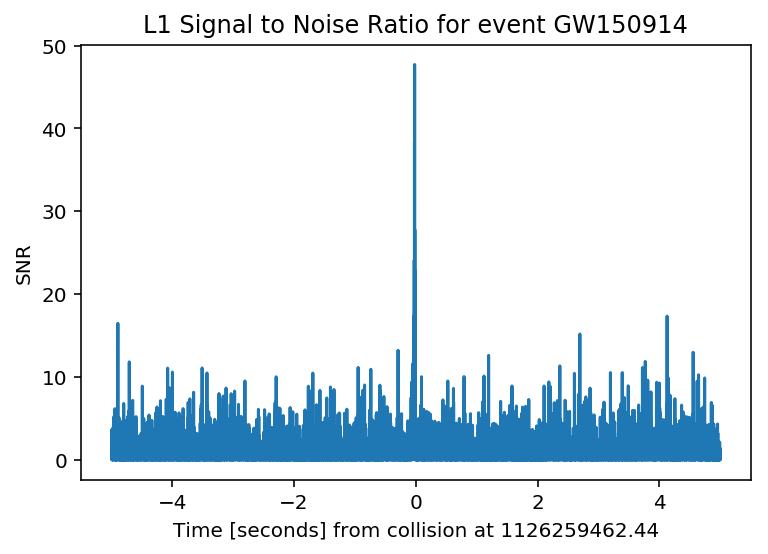

In [150]:
plt.plot(time[indxt]-tevent,L1_WBP_squared/L1_mean_power)
plt.title('L1 Signal to Noise Ratio for event '+str(eventname))
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('SNR')

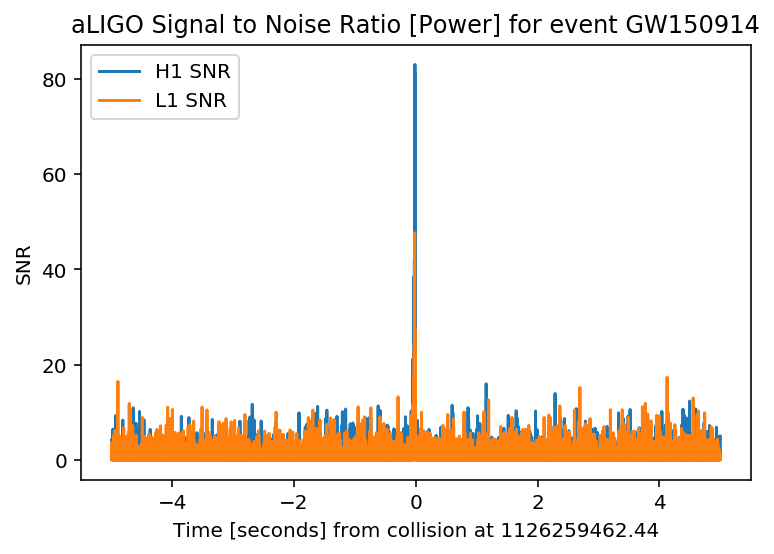

In [151]:
plt.plot(time[indxt]-tevent,H1_WBP_squared/H1_mean_power,label='H1 SNR')
plt.plot(time[indxt]-tevent,L1_WBP_squared/L1_mean_power,label='L1 SNR')
plt.title('aLIGO Signal to Noise Ratio [Power] for event '+str(eventname))
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('SNR')
plt.legend(loc='upper left')

So the plot we've just made is great, and we could easily just tell the computer, "hey just pick out wherever the SNR is greater than some number" (40, for example, would select the signal and nothing else). But we can smooth the noise across a longer time interval to avoid some of the higher frequency white noise.

Setting moving average (long) to  0.365966796875 seconds...
Setting moving average (short) to 0.121826171875 seconds...


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


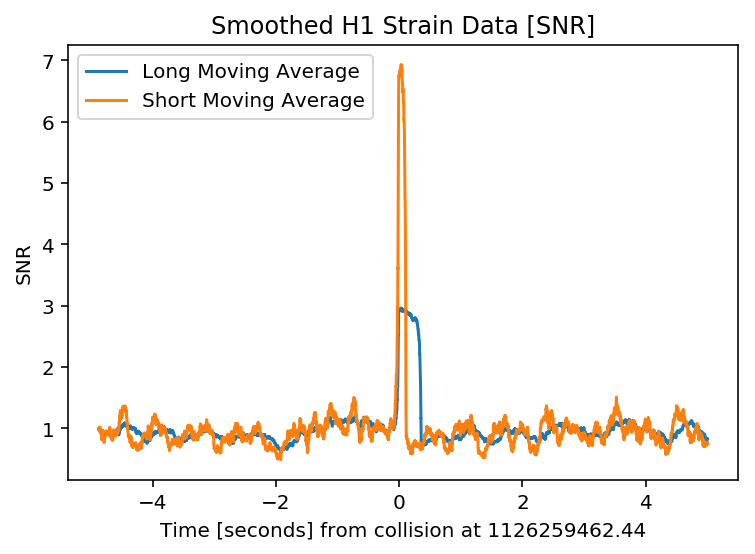

In [152]:
moving_average_long = []
moving_average_short = []

long = 1499
short = 499

print('Setting moving average (long) to  '+str(2*deltat*(long/len(time[indxt])))+' seconds...')
print('Setting moving average (short) to '+str(2*deltat*(short/len(time[indxt])))+' seconds...')



i = 0
while i < len(time[indxt]):
    moving_average_long.append(np.mean(H1_WBP_squared[i-long:i+1]))       #previously defined H1_WBP_squared to be:    H1_WBP_squared = np.array(strain_H1_whitenbp[indxt]**2)
    moving_average_short.append(np.mean(H1_WBP_squared[i-short:i+1]))
    
    i = i+1
    

plt.plot(time[indxt]-tevent, moving_average_long/H1_mean_power, label='Long Moving Average')
plt.plot(time[indxt]-tevent, moving_average_short/H1_mean_power, label='Short Moving Average')
plt.legend(loc='upper left')
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('SNR')
plt.title('Smoothed H1 Strain Data [SNR]')

## Taking a closer look at the moving average

So we're using these moving averages to find the signals. Let's take a look at what they actually do. On some level, it's exactly what it sounds like: an average that *moves* through the data, taking the average of the last second, quarter second, or whatever we want. By comparing a long moving average to a short moving average, we can see transient changes in the data.

Below is a zoom in of a small portion of data. showing how the whole thing works. Below, See how the orange curve jumps around frequently but the blue curve moves much more slowly? As currently written, the long moving average (blue) samples for three times more data than the short moving average (orange). So it represents a kind of short term baseline for the data (remember how the original baseline still had so much jitter?) If we subtract the long average from the short average, we'll have a much more accurate detection algorithm that's far less suceptable to sweeping changes or relatively low intensity stochastic noise.

As a side note, you may notice that the plot below looks more like a stock price than anything else. Well, it turns out that the price of stocks (for the short term) can be modeled with stochastic noise like this. In the interest of full disclosure, I've actually stolen the idea of long/short moving average comparison from stock algo traders (although I'm sure they didn't come up with it, either). The YouTube channel "Sentdex" has a really cool video series of how to build a stock trading algorithm on this principle. This is also related to the Donchian Channel, which is kind of like significance testing for stock values.

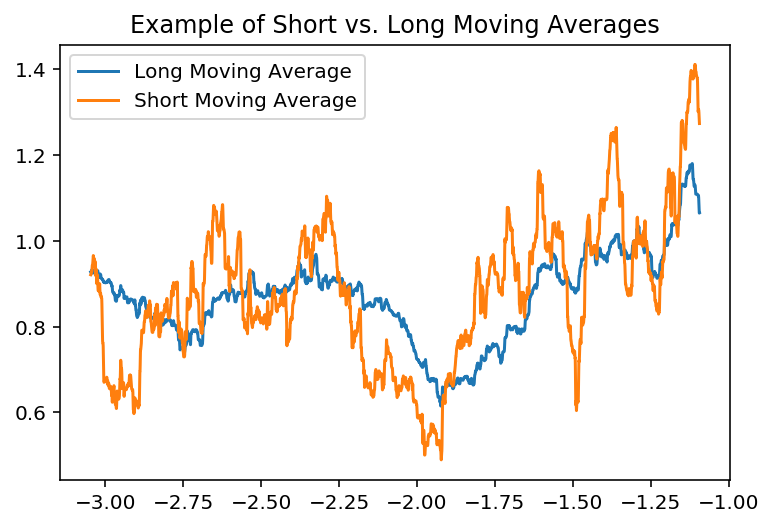

In [153]:
#print(time[indxt][8000]-tevent)     #figuring out where to find the right timestamps
#print(time[indxt][16000]-tevent)

# FOr this we just pick a shorter sample to illustrate the concept. 

#Stock market data or LIGO data? You decide!

plt.plot(time[indxt][8000:16000]-tevent, moving_average_long[8000:16000]/H1_mean_power, label='Long Moving Average')
plt.plot(time[indxt][8000:16000]-tevent, moving_average_short[8000:16000]/H1_mean_power, label='Short Moving Average')
plt.legend(loc='upper left')
plt.title('Example of Short vs. Long Moving Averages')

Now to see a movement, we can subtract the long from the short. In the cell below, we perform this operation and see the signal through the smoothing. 

Setting moving average (long) to  0.365966796875 seconds...
Setting moving average (short) to 0.121826171875 seconds...


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


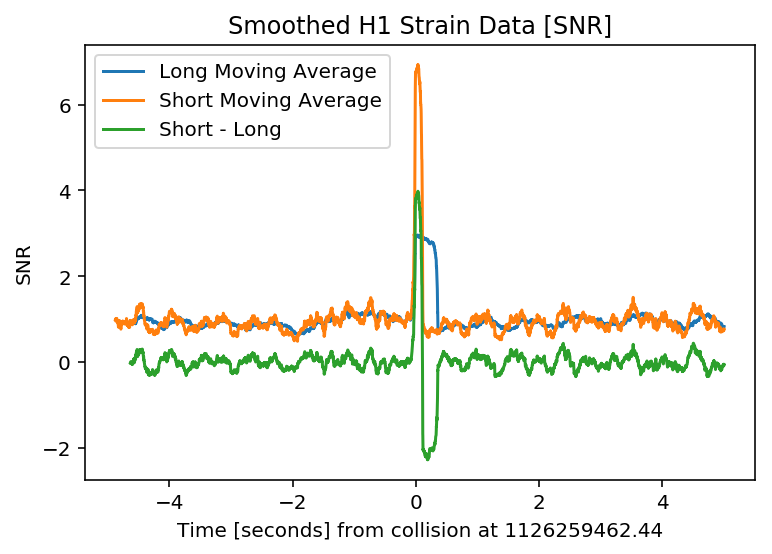

In [154]:
# Same code as above so you can make changes here instead of scrolling up...
# I've created a new array for the moving average SNR to do math...

moving_average_long = []
moving_average_short = []

long = 1499
short = 499

print('Setting moving average (long) to  '+str(2*deltat*(long/len(time[indxt])))+' seconds...')
print('Setting moving average (short) to '+str(2*deltat*(short/len(time[indxt])))+' seconds...')


i = 0
while i < len(time[indxt]):
    moving_average_long.append(np.mean(H1_WBP_squared[i-long:i+1]))
    moving_average_short.append(np.mean(H1_WBP_squared[i-short:i+1]))
    
    i = i+1


long_SNR_H1 = moving_average_long/H1_mean_power
short_SNR_H1 = moving_average_short/H1_mean_power

reduced_SNR_H1 = short_SNR_H1 - long_SNR_H1

plt.plot(time[indxt]-tevent, long_SNR_H1, label='Long Moving Average')
plt.plot(time[indxt]-tevent, short_SNR_H1, label='Short Moving Average')
plt.plot(time[indxt]-tevent, reduced_SNR_H1, label='Short - Long')

plt.legend(loc='upper left')
plt.xlabel('Time [seconds] from collision at '+str(tevent))
plt.ylabel('SNR')
plt.title('Smoothed H1 Strain Data [SNR]')

## Flagging Algorithm

We're almost there! Now we run the flagging algorithm, and plot the results over the regular data, which we've color coded for good measure. Finally, the Long - Short isn't really a data product, just a flagging tool, so we have the computer plot us back the Short time moving average (since it's smoother than the regular data).

Flagged excess power starting at t = 1126259462.41


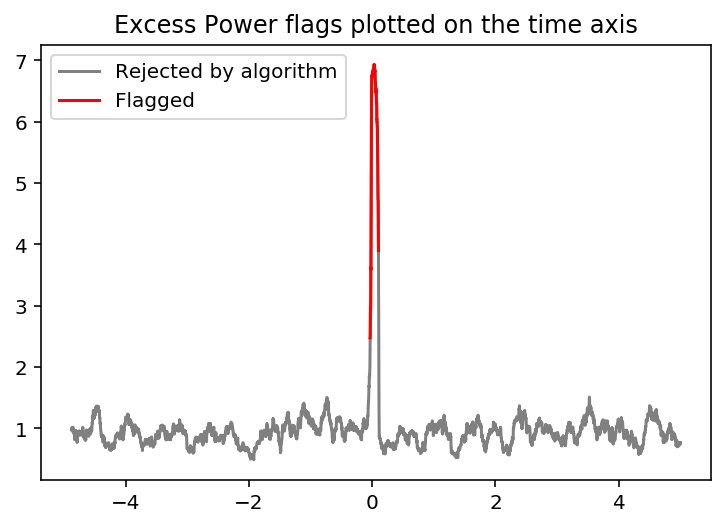

In [155]:
flag_times = []
flag_h1 = []

i=0
while i < len(reduced_SNR_H1):
    if reduced_SNR_H1[i] > 1.0:
        flag_times.append(time[indxt][i])
        flag_h1.append(short_SNR_H1[i])
        i = i+1
    else:
        #print(i)     #troubleshooting
        i=i+1
print('Flagged excess power starting at t = '+str(flag_times[0]))
        
j=0
while j < len(flag_times):
    flag_times[j] = flag_times[j] - tevent
    j = j+1


    
plt.plot(time[indxt]-tevent, short_SNR_H1, label='Rejected by algorithm',color='gray')
plt.plot(flag_times, flag_h1, label='Flagged', color='red')
plt.legend(loc='upper left')
plt.title('Excess Power flags plotted on the time axis')

## Putting it all together: A worked example

So now we have a detection algorithm that works properly and flags the data! Thing is, I've only been testing it using one detector. Let's put all the peices together to come up code that works for both detectors on any event.

I want to be able to run *just this part* of the code, so the first cell below is copied directly from the first cell of the notebook. If you've already impoted all this stuff, you can skip it.

Cell number two allows us to pick an event. I'm using the first event for this example. Once again, this is the same as the cell from before.

Cell three perfoms the data reduction. This is also the same as the cell from before.

In [203]:
#WK: This is all pretty basic stuff.
#    I've made it its own cell becuase the imports take a little while and only need to be run once.

# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt                       #WK: When you import packages you can refer to them as anything. It is standard practive to refer to matplotlib's plotting package as "plt".
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

# want plots?
#WK: Set to 0 if you don't want plots.
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [204]:
#WK: For this worked example I'm using GW150914, but you can use others.

eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'


Reading in parameters for event GW150914
{'fn_L1': 'L-L1_LOSC_4_V1-1126259446-32.hdf5', 'fn_H1': 'H-H1_LOSC_4_V1-1126259446-32.hdf5', 'f_min': 10.0, 'name': 'GW150914', 'utcevent': '2015-09-14T09:50:45.44', 'a2': -0.769, 'fs': 4096, 'fn_template': 'GW150914_4_template.hdf5', 'm1': 41.743, 'approx': 'lalsim.SEOBNRv2', 'm2': 29.237, 'a1': 0.355, 'tevent': 1126259462.44, 'fband': [43.0, 300.0]}
time_H1: len, min, mean, max =  131072 1126259446.0 1126259462.0 1126259478.0
strain_H1: len, min, mean, max =  131072 -7.11996338709e-19 8.73279794057e-23 7.71483633765e-19
strain_L1: len, min, mean, max =  131072 -2.6788089173e-18 -1.82870749189e-18 -7.69266177024e-19
1126259462.44
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


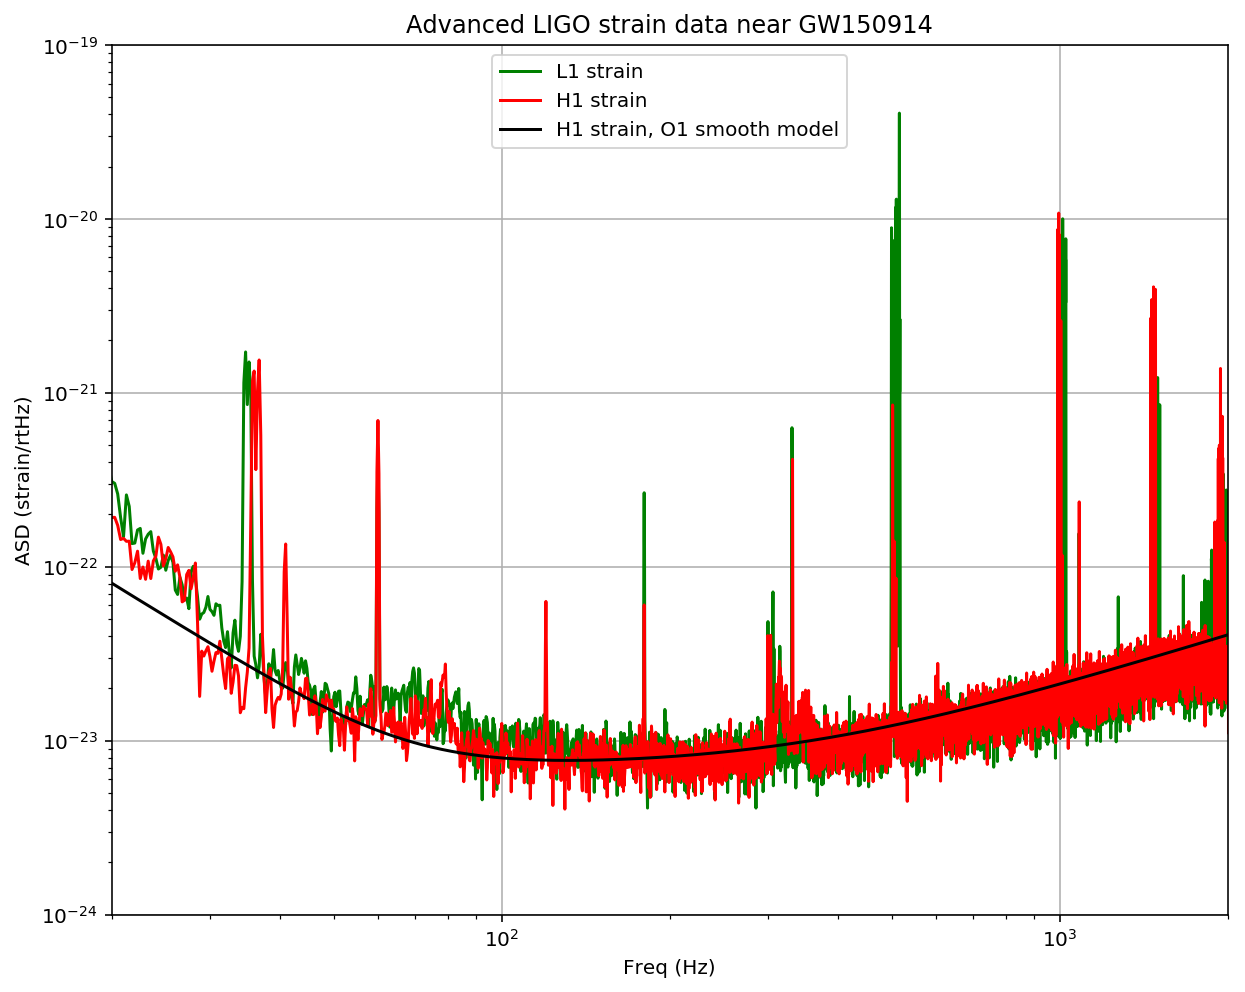

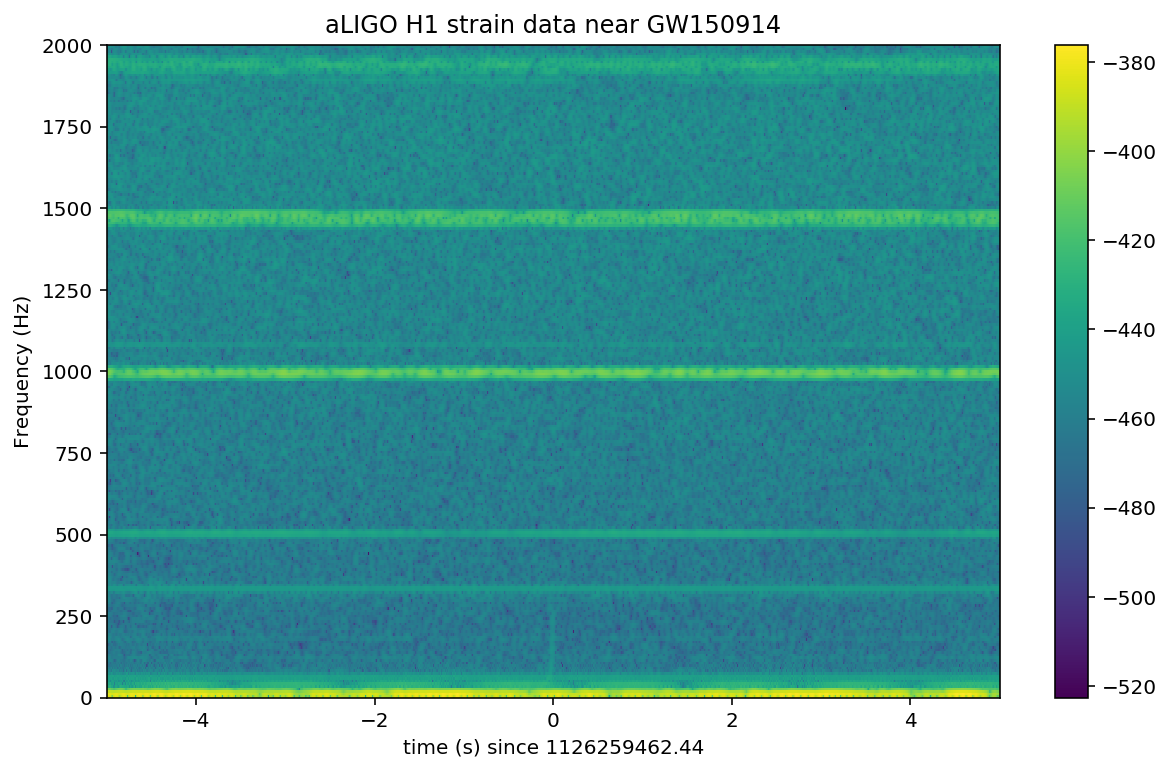

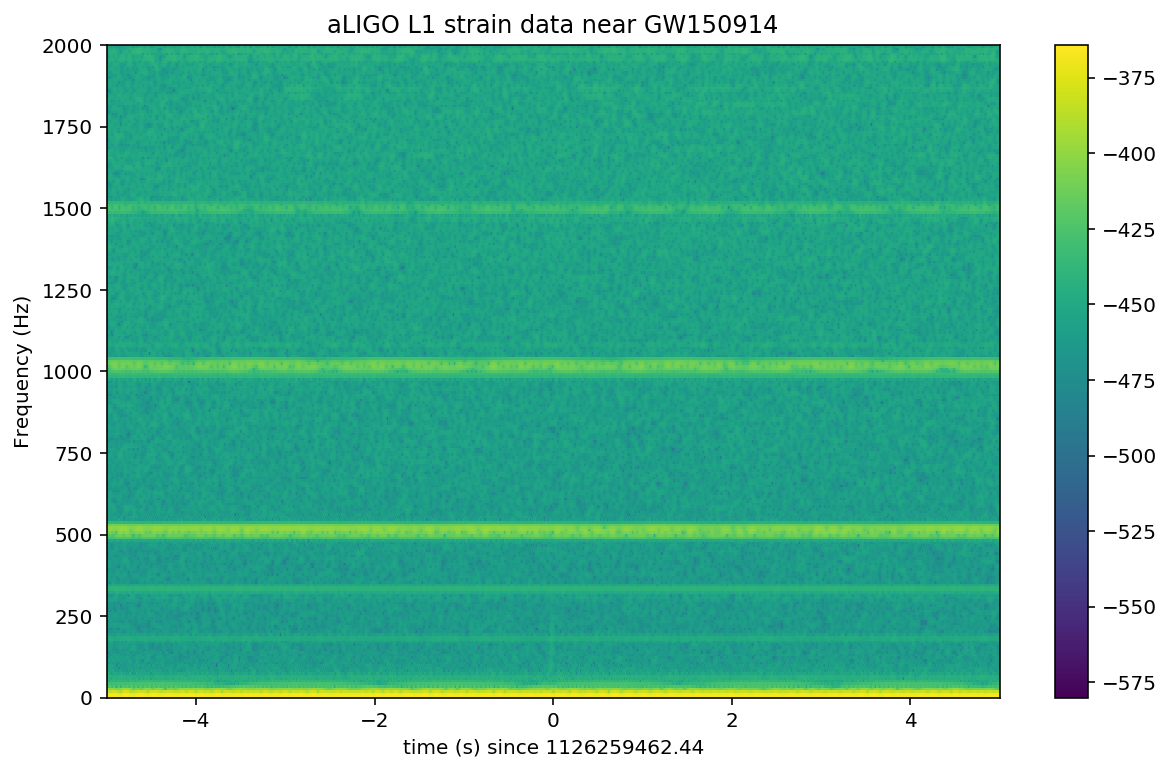

In [205]:
#WK: This is cobbled together from the other LIGO cells.
# The gist is that it loads the data from a json file, with the name specified by "eventname" above.
# It takes the data from the file and converts everything into arrays, which Python can do math on.
# The arrays are the raw data, and we perform math to whiten the data and otherwise reduce it to usable format.
# The arrays are FFT'ed at some point as well.
# Finally, we can plot the data using a few different visualization methods, all provided via matplotlib.


# Read the event properties from a local json file
#fnjson = "BBH_events_v3.json"
fnjson = "BBH_events_v2.json"   #Added this because this is the filename I found in the directory
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])    # WK: leaving some verbose feedback here deliberately
print(event)

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
    
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
    
#FFT stuffs read in from previous cells    
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)
    
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization
    
#Start by stealing the plotting code from the cells below.
#Next we need to define the event for each cell to plot them all.

if make_plots:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    #WK: Windowing is super important to get a good roll-off for your spectrum. Otherwise, the hard boundary imposes a weird square wave which will appear as a ~1/f series of peaks in your FFT that ruin everything
    #WK: https://en.wikipedia.org/wiki/Window_function
    
    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    spec_cmap='viridis'   #WK: If this doesn't work, switch the color map back to ocean (see commented line below)
    #spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)

    # Plot the L1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram.'+plottype)



#WK: You may get a deprecation warning. This is fine. Python is smart enough to turn a float (eg: 3.00) into an integer (eg: 3). Not all languages (or even versions of Python) can do this.



We now have all the basic LIGO data products loaded. They're not plotted here, but recall that this code creates the raw strain value, the whitened strain, and the whitened strain with a bandpass for the GW frequencies we expect.

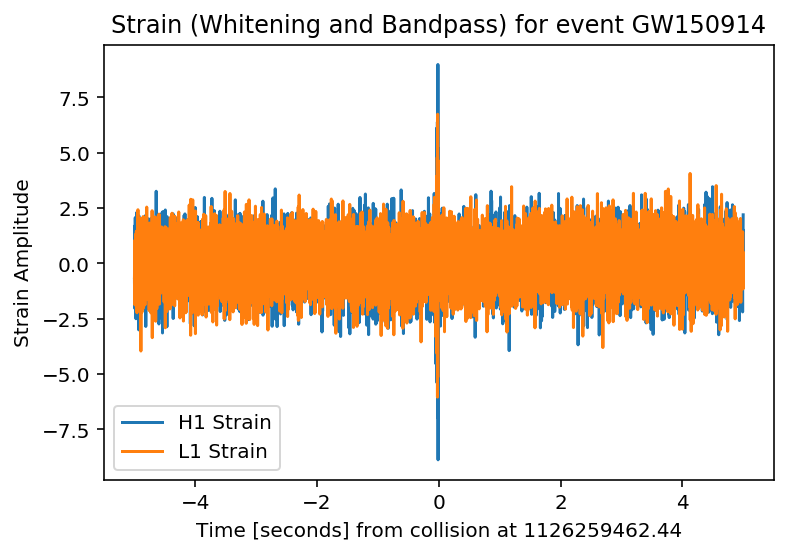

In [206]:
#make_plots = 1

if make_plots:
    plt.plot(time[indxt]-tevent,strain_H1_whitenbp[indxt],label='H1 Strain')
    plt.plot(time[indxt]-tevent,strain_L1_whitenbp[indxt],label='L1 Strain')
    plt.title('Strain (Whitening and Bandpass) for event '+str(eventname))
    plt.xlabel('Time [seconds] from collision at '+str(tevent))
    plt.ylabel('Strain Amplitude')
    plt.legend(loc='lower left')

0.971770716482
0.951622458868


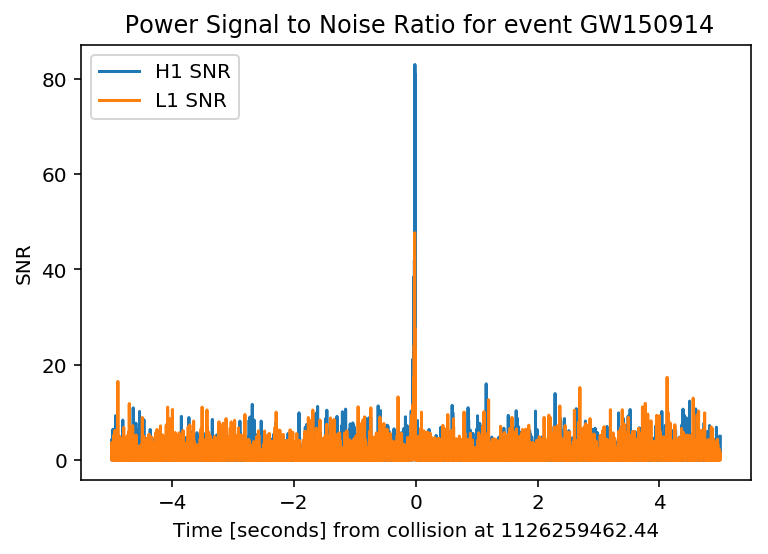

In [207]:
# Take all the datapoints and square them. Use the np.array() because np is smarter than vanilla python?
H1_WBP_squared = np.array(strain_H1_whitenbp[indxt]**2)
L1_WBP_squared = np.array(strain_L1_whitenbp[indxt]**2)

# Now take an average for the 
H1_mean_power = np.mean(H1_WBP_squared)
L1_mean_power = np.mean(L1_WBP_squared)

print(H1_mean_power)
print(L1_mean_power)

# It would seem I'm wrong about using np.array(). The code below proves it's not actually required.
# Numpy arrays usually are smarter and/or intuitive, but I guess in this instance it doesn't matter
#a = strain_H1_whitenbp[indxt]**2
#print(np.shape(a))
#print(strain_H1_whitenbp[indxt][0]**2)
#print(a[0])

if make_plots:
    plt.plot(time[indxt]-tevent,H1_WBP_squared/H1_mean_power,label='H1 SNR')
    plt.plot(time[indxt]-tevent,L1_WBP_squared/L1_mean_power,label='L1 SNR')
    plt.title(' Power Signal to Noise Ratio for event '+str(eventname))
    plt.xlabel('Time [seconds] from collision at '+str(tevent))
    plt.ylabel('SNR')
    plt.legend(loc='upper left')

Setting moving average (long) to  0.365966796875 seconds...
Setting moving average (short) to 0.121826171875 seconds...


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


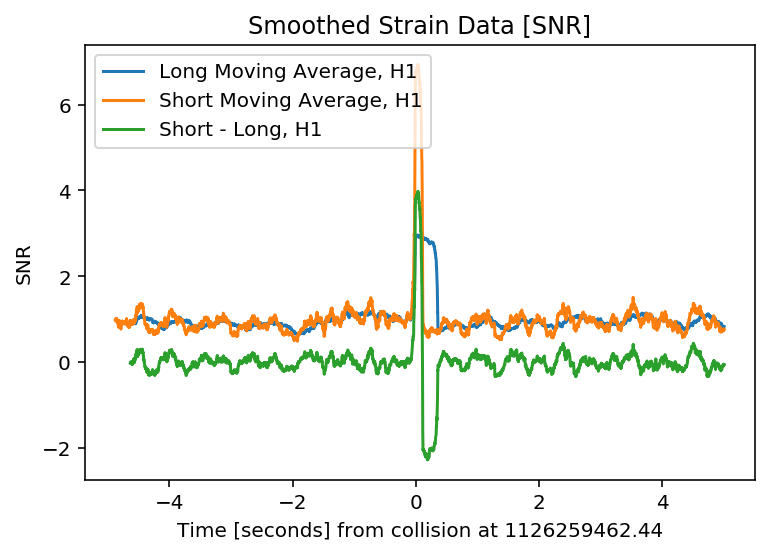

In [208]:
# Make some empty arrays for the new data
moving_average_long_H1 = []
moving_average_short_H1 = []
moving_average_long_L1 = []
moving_average_short_L1 = []

long = 1499
short = 499

print('Setting moving average (long) to  '+str(2*deltat*(long/len(time[indxt])))+' seconds...')
print('Setting moving average (short) to '+str(2*deltat*(short/len(time[indxt])))+' seconds...')


i = 0
while i < len(time[indxt]):
    moving_average_long_H1.append(np.mean(H1_WBP_squared[i-long:i+1]))
    moving_average_short_H1.append(np.mean(H1_WBP_squared[i-short:i+1]))
    moving_average_long_L1.append(np.mean(L1_WBP_squared[i-long:i+1]))
    moving_average_short_L1.append(np.mean(L1_WBP_squared[i-short:i+1]))
    i = i+1


long_SNR_H1 = moving_average_long_H1/H1_mean_power
short_SNR_H1 = moving_average_short_H1/H1_mean_power
long_SNR_L1 = moving_average_long_L1/L1_mean_power
short_SNR_L1 = moving_average_short_L1/L1_mean_power

reduced_SNR_H1 = short_SNR_H1 - long_SNR_H1
reduced_SNR_L1 = short_SNR_L1 - long_SNR_L1

if make_plots:
    plt.plot(time[indxt]-tevent, long_SNR_H1, label='Long Moving Average, H1')
    plt.plot(time[indxt]-tevent, short_SNR_H1, label='Short Moving Average, H1')
    plt.plot(time[indxt]-tevent, reduced_SNR_H1, label='Short - Long, H1')
    #plt.plot(time[indxt]-tevent, long_SNR_L1, label='Long Moving Average, L1')
    #plt.plot(time[indxt]-tevent, short_SNR_L1, label='Short Moving Average, L1')
    #plt.plot(time[indxt]-tevent, reduced_SNR_L1, label='Short - Long, L1')
    plt.legend(loc='upper left')
    plt.xlabel('Time [seconds] from collision at '+str(tevent))
    plt.ylabel('SNR')
    plt.title('Smoothed Strain Data [SNR]')

Now finally plot the detected excess power in red...

Flagged excess power starting at t = 1126259462.41


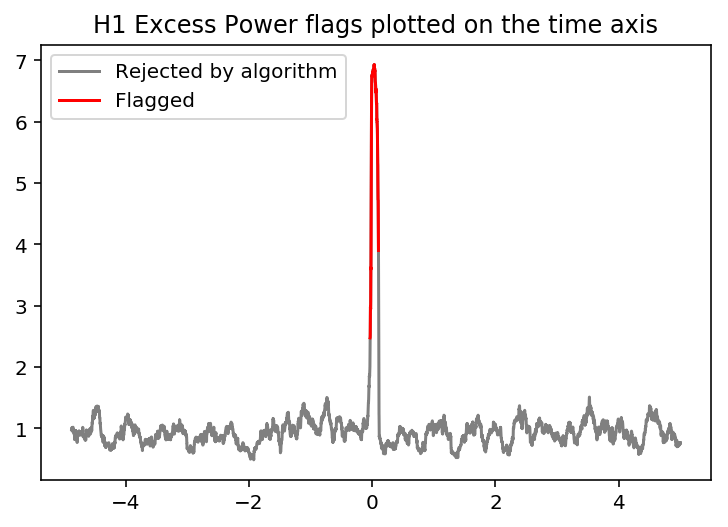

In [209]:
flag_times_H1 = []
flag_H1 = []


i=0
while i < len(reduced_SNR_H1):
    if reduced_SNR_H1[i] > 1.0:
        flag_times_H1.append(time[indxt][i])
        flag_H1.append(short_SNR_H1[i])
        i = i+1
    else:
        #print(i)     #troubleshooting
        i=i+1
print('Flagged excess power starting at t = '+str(flag_times_H1[0]))
        
j=0
while j < len(flag_times_H1):
    flag_times_H1[j] = flag_times_H1[j] - tevent
    j = j+1


    
plt.plot(time[indxt]-tevent, short_SNR_H1, label='Rejected by algorithm',color='gray')
plt.plot(flag_times_H1, flag_H1, label='Flagged', color='red')
plt.legend(loc='upper left')
plt.title('H1 Excess Power flags plotted on the time axis')

Flagged excess power starting at t = 1126259462.42


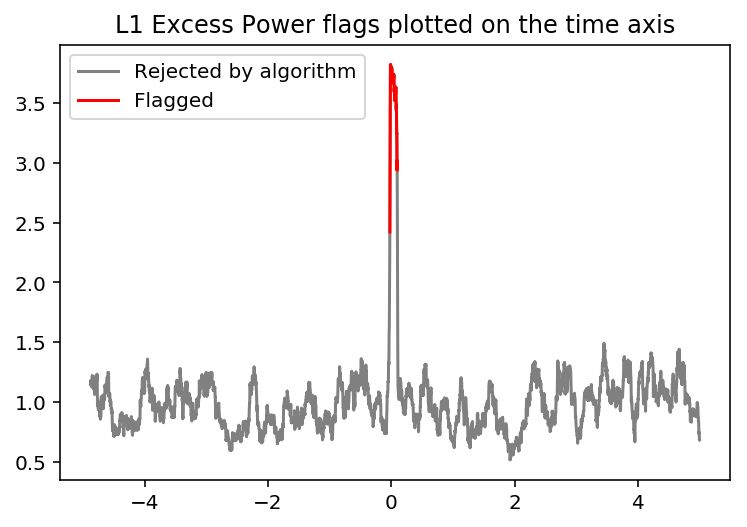

In [210]:
flag_times_L1 = []
flag_L1 = []


i=0
while i < len(reduced_SNR_L1):
    if reduced_SNR_L1[i] > 1.0:
        flag_times_L1.append(time[indxt][i])
        flag_L1.append(short_SNR_L1[i])
        i = i+1
    else:
        #print(i)     #troubleshooting
        i=i+1
print('Flagged excess power starting at t = '+str(flag_times_L1[0]))
        
j=0
while j < len(flag_times_L1):
    flag_times_L1[j] = flag_times_L1[j] - tevent
    j = j+1


    
plt.plot(time[indxt]-tevent, short_SNR_L1, label='Rejected by algorithm',color='gray')
plt.plot(flag_times_L1, flag_L1, label='Flagged', color='red')
plt.legend(loc='upper left')
plt.title('L1 Excess Power flags plotted on the time axis')